<a href="https://colab.research.google.com/github/dgilmore33/volatilitySurface/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install uncommon dependencies
!pip install QuantLib
!pip install yfinance

     |████████████████████████████████| 20.1MB 1.5MB/s 
     |████████████████████████████████| 6.3MB 4.1MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=4fa00219edc5bd4da958022a170e060de32e66d2385b9663b97a101b77d0a782
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import datetime
import math
import numpy as np
import numpy.polynomial.polynomial as poly
import pandas as pd
import QuantLib as ql
import scipy
import yfinance as yf

from datetime import datetime, timedelta
from google.colab import drive
from math import pow, sqrt, log, exp
from matplotlib import pyplot as plt, cm
from numpy import random
from scipy.interpolate import griddata, interp1d, interp2d, LinearNDInterpolator, SmoothBivariateSpline
from scipy.misc import derivative
from scipy.optimize import brentq, newton, linear_sum_assignment
from scipy.spatial.distance import cdist
from scipy.stats import norm

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Here we read the option chain data.
1. We convert the **Ask** column to a float dtype
2. Timestamp **Expiration Date**, then convert to a float dtype


In [ ]:
# Read CSV Containing Option Data and Do Some Cleanup of Dataframe

path = "/content/drive/MyDrive/MATH424_Final/spx_quotedata_0406.csv"
quotes_df = pd.read_csv(path)
quotes_df.Ask = quotes_df.Ask.astype("float")
quotes_df = quotes_df.drop("Unnamed: 0", axis=1)
quotes_df["Expiration Date"] = pd.to_datetime(quotes_df["Expiration Date"])
quotes_df["Expiration Date"] = quotes_df["Expiration Date"].apply(lambda x : x.timestamp())
quotes_df["Expiration Date"] = quotes_df["Expiration Date"].astype("float")
quotes_df = quotes_df[quotes_df['Volume'] > 50]

In [ ]:
# Set Important Constants

d = datetime(2021, 4, 6) # option data date
t0 = int(d.strftime('%s'))
s0 = float(yf.download("^GSPC", start=d, end=(d + timedelta(days=1)))["Open"])
r = 0.0005

[*********************100%***********************]  1 of 1 completed


Calculate Time to Expiration, **T**. Formula:
>$(\text{Expiration Date} - t0)\text{ seconds}\times\frac{1 \text{min}}{60 \text{seconds}}\times\frac{1 \text{hour}}{60 \text{minutes}}\times\frac{1 \text{day}}{24 \text{hours}}\times\frac{1 \text{year}}{364.25 \text{days}}$

In [ ]:
quotes_df["T"] = (quotes_df["Expiration Date"] - t0)/(60*60*24*364.25)
quotes_df["T"] = quotes_df["T"].astype("float")
quotes_df = quotes_df[quotes_df["T"] != 0]

[Initial Estimate for Sigma](https://quant.stackexchange.com/questions/7761/a-simple-formula-for-calculating-implied-volatility):
> $\sigma = \sqrt{\frac{2\pi}{T}}\times\frac{C}{S_0}$

In [ ]:
quotes_df["Sigma Init"] = np.sqrt((2*np.pi)/quotes_df["T"])*(quotes_df["Last Sale"]/s0)
quotes_df["Sigma Init"].replace(0, .01, inplace=True)

In [ ]:
# Take Mean of Ask and Bid as Market Value of Call Option
quotes_df["C"] = (quotes_df['Ask'] + quotes_df["Bid"])/2

[Black Scholes Formula](https://www.google.com/search?client=safari&rls=en&q=black+scholes+formula&ie=UTF-8&oe=UTF-8):
>$C = \phi(d_1)S_t - \phi(d_2)Ke^{rT}$ \\
> $d_1 = \frac{\ln\frac{S_t}{K}+(r+\frac{\sigma^2}{2})t}{\sigma\sqrt{t}}$ \\
>$d_2 = d_1 - \sigma\sqrt{t}$ \\
>$f(\sigma) = \phi(d_1)S_t - \phi(d_2)Ke^{rT} - C$ \\
>$f'(\sigma) = f(d_1)S_t \cdot d_1' - \frac{K}{e^{rt}}f(d_2)\cdot d_2'$
>$ $

In [ ]:
def BS(sigma, c, k, t):
    d1 = (log(s0/k) + (r+(sigma**2)/2)*t) / (sigma*sqrt(t))
    d2 = d1-sigma*sqrt(t)
    return s0*norm.cdf(d1) - k*exp(-r*t)*norm.cdf(d2) - c

In [ ]:
def BS_prime(sigma, c, k, t):
    d1 = (log(s0/k) + (r+(sigma**2)/2)*t) / (sigma*sqrt(t))
    d2 = d1-sigma*sqrt(t)
    d1_p = ((sigma**2)*t*sqrt(t)-(np.log(s0/k)+(r+(sigma**2)/2)*t)*sqrt(t))/((sigma**2)*t)
    d2_p = d1_p - sqrt(t)
    return s0*norm.pdf(d1)*d1_p - k*exp(-r*t)*norm.pdf(d2)*d2_p

In [ ]:
def BS_orig(sigma, k, t):
    d1 = (log(s0/k) + (r+(sigma**2)/2)*t) / (sigma*sqrt(t))
    d2 = d1-sigma*sqrt(t)
    return s0*norm.cdf(d1) - k*exp(-r*t)*norm.cdf(d2)

In [ ]:
# Remove options with where implied cannot be calculated (should only be a few)

quotes_df = quotes_df[quotes_df.apply(lambda row: BS(0.001, row["C"], row["Strike"], row["T"]) <= 0, axis=1)]
quotes_df = quotes_df[quotes_df.apply(lambda row: BS(1, row["C"], row["Strike"],  row["T"]) > 0, axis=1)]

Define root solving algithms to get implied volatility

In [ ]:
def brent_apply(row):
    return brentq(BS, a=0.001, b=1, args=(row["C"], row["Strike"], row["T"]))

quotes_df["Sigma Brent"] = quotes_df.apply(brent_apply, axis=1)

In [ ]:
def newton_apply(row):
    return newton(BS, 1, fprime=BS_prime, args=(row["C"], row['Strike'], row['T']), tol=0.0001)

quotes_df["Sigma Newton"] = quotes_df.apply(newton_apply, axis=1)

### Calculating Implied Volatility Surface

In [ ]:
# Remove Maturities and Strikes Where data is Spare So That Interpolation is Better

qdf = quotes_df.copy()

for t in np.unique(qdf["T"].to_numpy()):
    if len(qdf[qdf['T'] == t].index) <= 3:
        qdf = qdf[qdf['T'] != t]

for k in np.unique(qdf["Strike"].to_numpy()):
    if len(qdf[qdf['Strike'] == k].index) <= 5:
        qdf = qdf[qdf['Strike'] != k]

In [ ]:
# Create implied volatility matrix and option price matrix and interpolate data to fill matricies

# Define columns and rows of matrix as strikes and maturities
Ts = np.sort(np.unique(qdf["T"].to_numpy()))
Ks = np.sort(np.unique(qdf["Strike"].to_numpy()))
X, Y = np.meshgrid(Ks, Ts)

IVs = np.full((Ts.shape[0], Ks.shape[0]), None)
Cs = np.full((Ts.shape[0], Ks.shape[0]), None)

for row, T in enumerate(Ts):
    qdf_temp = qdf[qdf['T'] == T]
    for col, K in enumerate(Ks):
        iv = qdf_temp[qdf_temp['Strike'] == K]
        if len(iv.index) > 0:
            IVs[row, col] = iv.iloc[0]['Sigma Newton']
            Cs[row, col] = int(iv.iloc[0]["C"])

for i in range(IVs.shape[0]):
    x = []
    y = []
    x_new = []
    x_new_i = []
    y_new = []
    for j in range(IVs.shape[1]):
        if IVs[i,j] != None:
            x.append(Ks[j])
            y.append(IVs[i,j])
        else:
            x_new.append(Ks[j])
            x_new_i.append(j)

    coefs = poly.polyfit(x, y, 2)
    y_new = poly.polyval(x_new, coefs)
    
    for j, val in enumerate(y_new):
        IVs[i,x_new_i[j]] = val
        Cs[i,x_new_i[j]] = BS_orig(val, Ks[x_new_i[j]], Ts[i])

IVs = IVs.astype(np.float64)
IVs[IVs>1] = 1
IVs[IVs<0] = 0
Cs = Cs.astype(np.float64)

/usr/local/lib/python3.7/dist-packages/numpy/polynomial/polynomial.py:1350: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


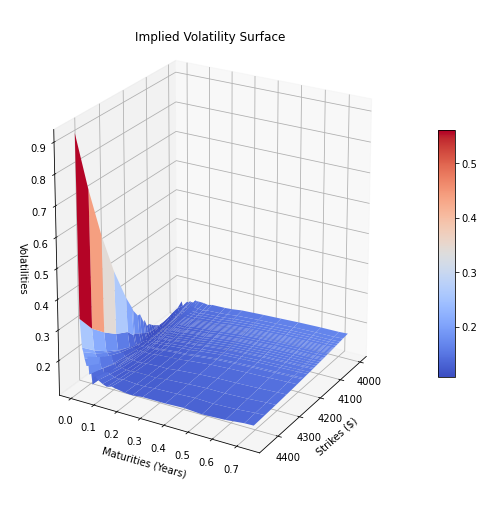

In [ ]:
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)

ax1 = fig.add_subplot(2, 2, 1, projection='3d',xlabel='Strikes ($)',ylabel='Maturities (Years)', zlabel='Volatilities',title='Implied Volatility Surface')
surf1=ax1.plot_surface(X, Y, IVs, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0.1)
fig.colorbar(surf1, shrink=0.5, aspect=15)
ax1.view_init(elev=20., azim=30)

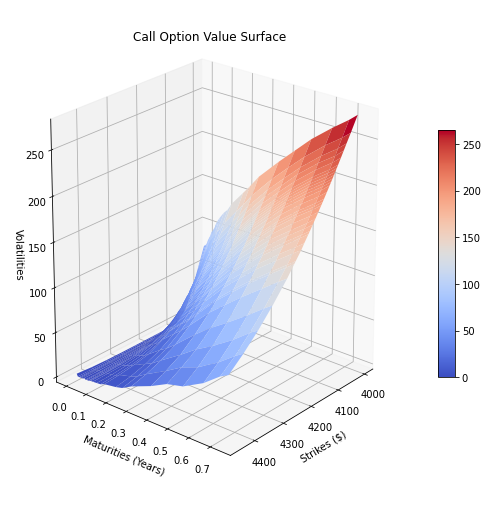

In [ ]:
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)

ax1 = fig.add_subplot(2, 2, 1, projection='3d',xlabel='Strikes ($)',ylabel='Maturities (Years)', zlabel='Volatilities',title='Call Option Value Surface')
surf1=ax1.plot_surface(X, Y, Cs, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0.1)
fig.colorbar(surf1, shrink=0.5, aspect=15)
ax1.view_init(elev=20., azim=40)

In [ ]:
#Find Derivatives of Call Option Value Surface Using Spline Interpolated Call Value Surface

def spline_interpolate(X, Y, Z, kx=3, ky=3):
    return SmoothBivariateSpline(X.reshape((-1,)), Y.reshape((-1,)), Z.reshape((-1,)), kx=kx, ky=ky)

f = spline_interpolate(X,Y,Cs, kx=2, ky=5)

DCT = f.ev(X, Y, dy=1)

DCK2 = np.empty(Cs.shape)
for i in range(IVs.shape[0]):
    for j in range(IVs.shape[1]):
        delta = 0.1
        DCK2[i,j] = (f.ev(Ks[j] - delta, Ts[i]) - 2*f.ev(Ks[j], Ts[i]) + f.ev(Ks[j] + delta, Ts[i]))/(delta**2)

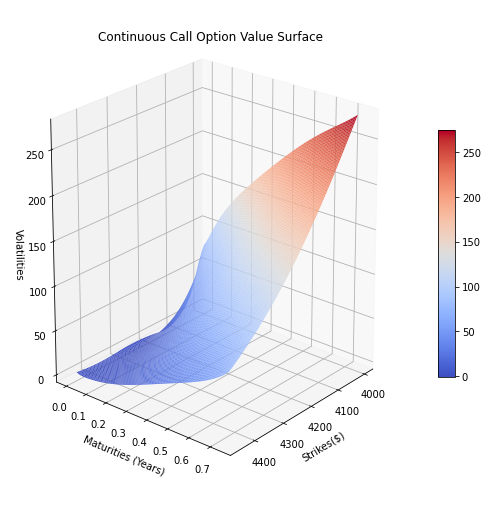

In [ ]:
# Plot Continuous Call Value Surface Function for Comparison

fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)

XX = np.linspace(np.min(Ks), np.max(Ks), 100)
YY = np.linspace(np.min(Ts), np.max(Ts), 100)
XX, YY = np.meshgrid(XX, YY)

Zs = f.ev(XX,YY)

ax1 = fig.add_subplot(2, 2, 1, projection='3d',xlabel='Strikes($)',ylabel='Maturities (Years)', zlabel='Volatilities',title='Continuous Call Option Value Surface')
surf1=ax1.plot_surface(XX, YY, Zs, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0.1)
fig.colorbar(surf1, shrink=0.5, aspect=15)
ax1.view_init(elev=20., azim=40)

### Calculating Local Volatility Using Option Value Surface

>$\sigma^2(K,T) = \frac{\frac{\partial C}{\partial T}}{ \frac{1}{2} K^2 \frac{\partial^2C}{\partial K^2}}$

In [ ]:
def dupires_eq(K, dct, dck2):
  return sqrt(abs(dct/(0.5*(K**2)*dck2)))

In [ ]:
# Find Local Volatilities Using Dupires Equation

LVs = np.zeros(IVs.shape).astype(np.float64)
for i in range(IVs.shape[0]):
    for j in range(IVs.shape[1]):
        LVs[i,j] = dupires_eq(Ks[j], DCT[i,j], DCK2[i,j])

LVs[LVs>1] = 1
LVs[LVs<0] = 0

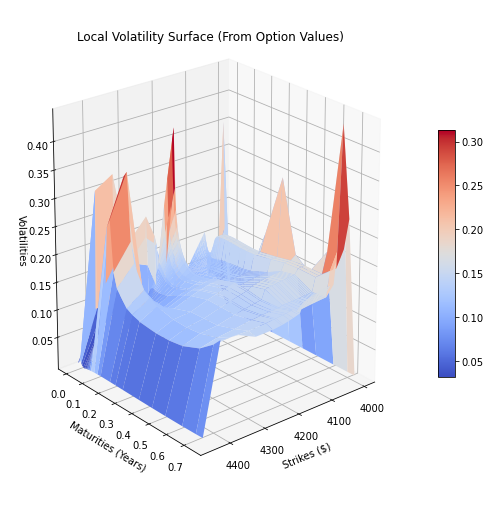

In [ ]:
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)

ax1 = fig.add_subplot(2, 2, 1, projection='3d',xlabel='Strikes ($)',ylabel='Maturities (Years)', zlabel='Volatilities',title='Local Volatility Surface (From Option Values)')
surf1=ax1.plot_surface(X, Y, LVs, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0.1)
fig.colorbar(surf1, shrink=0.5, aspect=15)
ax1.view_init(elev=20., azim=50)

### Calculating Local Volatility From Implied Volatility Surface

In [ ]:
# Create columns for total variance and log strike
quotes_df['w total var'] = quotes_df['Sigma Newton'] ** 2 * quotes_df["T"]
quotes_df['log strike y'] = np.log(quotes_df['Strike'] / (s0 * np.exp(r*quotes_df["T"])))

# Use only the strikes and times that have high volume, in order to get better interpolation
high_volume = quotes_df[quotes_df['T'] < 0.1]
high_volume = high_volume[high_volume['Strike'] > 3800]
high_volume = high_volume[high_volume['Strike'] < 4700]
#Interpolate implied volatility surface
var_interp = interp2d(high_volume['T'], high_volume['log strike y'], high_volume['w total var'])

/usr/local/lib/python3.7/dist-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=13,31 m=315 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [ ]:
def partial_derivative(func, var=0, point=[], n=1):
    def wraps(x):
        args[var] = x
        return func(*args)
    args = point[:]
    return derivative(wraps, point[var], dx = 1e-6, n=n)

In [ ]:
# Returns local variance from implied volatility derivatives
def local_var(y, w, pw_t, pw_y, p2w_y2):
    num = pw_t
    den = 1 - y/w * pw_y + 1/4*(0-1/4-1/w+y**2/w**2)*pw_y**2 + 1/2*p2w_y2
    return num/den

In [ ]:
# Add columns for partial derivatives
pw_t = []
pw_y = []
p2w_y2 = []
for i in range(len(high_volume['T'])):
    y = high_volume.iloc[i]['log strike y']
    t = high_volume.iloc[i]['T']
    pw_t.append(partial_derivative(var_interp, var=0, point=[t, y])[0])
    pw_y.append(partial_derivative(var_interp, var=1, point=[t, y])[0])
    p2w_y2.append(partial_derivative(var_interp, var=1, point=[t, y], n=2)[0])

high_volume['pw_t'] = pw_t
high_volume['pw_y'] = pw_y
high_volume['p2w_y2'] = p2w_y2

In [ ]:
# Add column for local volatility
lv = []
for i in range(len(high_volume)):
    row = high_volume.iloc[i]
    lv.append(local_var(row['log strike y'], row['w total var'], row['pw_t'], row['pw_y'], row['p2w_y2']))

# Clip values at 0 and 1
for i in range(len(lv)):
    if lv[i] < 0:
        lv[i] = 0
    if lv[i] > 1:
        lv[i] = 1

high_volume['local vol'] = np.sqrt(lv)

In [ ]:
# Interpolate local volatility surface for later use
lv_arr_interp = interp2d(high_volume['Strike'], high_volume['T'], high_volume['local vol'], kind="linear")
def lv_interp(strike, T):
  return lv_arr_interp(strike, T)[0]


/usr/local/lib/python3.7/dist-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=25,16 m=315 fp=0.471161 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


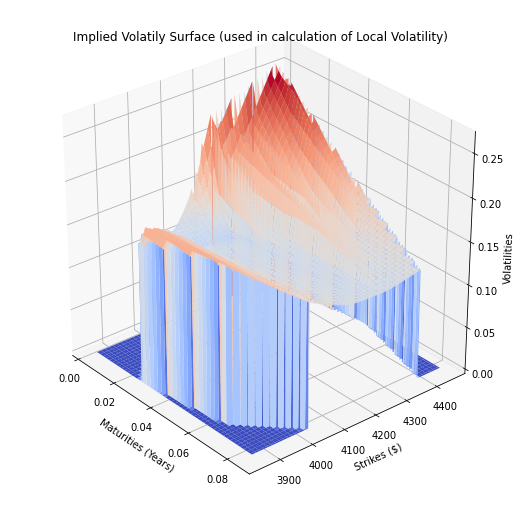

In [ ]:
#Plotting the interpolated implied volatility surface which was used to generate local volatility
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)

ax = fig.add_subplot(2, 2, 1, projection='3d',ylabel='Strikes ($)',xlabel='Maturities (Years)', zlabel='Volatilities',title='Implied Volatily Surface (used in calculation of Local Volatility)')
T = high_volume["T"].to_numpy()
K = high_volume["Strike"].to_numpy()
Sigma = high_volume["Sigma Brent"].to_numpy()
grid_x, grid_y = np.mgrid[min(T):max(T):340j, min(K):max(K):340j]
grid_z = griddata((T,K), Sigma, (grid_x, grid_y))
T = np.unique(T)
K = np.unique(K)
n = len(Sigma)/len(T)
m = len(Sigma)/len(K)
dt = np.linspace(T[0], T[-1], int(len(T)*n))
dk = np.linspace(K[0], K[-1], int(len(K)*m))
grid_z = np.nan_to_num(grid_z)

ax.plot_surface(grid_x, grid_y, grid_z, cmap=cm.coolwarm)
ax.view_init(elev=30., azim=-40)
plt.show()

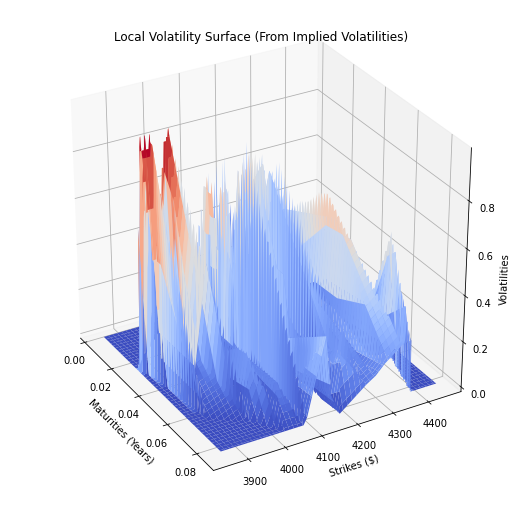

In [ ]:
#Plot local volatility

fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)

ax = fig.add_subplot(2, 2, 1, projection='3d',ylabel='Strikes ($)',xlabel='Maturities (Years)', zlabel='Volatilities',title="Local Volatility Surface (From Implied Volatilities)")
T = high_volume["T"].to_numpy()
K = high_volume["Strike"].to_numpy()
Sigma = high_volume["local vol"].to_numpy()
grid_x, grid_y = np.mgrid[min(T):max(T):340j, min(K):max(K):340j]
grid_z = griddata((T,K), Sigma, (grid_x, grid_y))
T = np.unique(T)
K = np.unique(K)
n = len(Sigma)/len(T)
m = len(Sigma)/len(K)
dt = np.linspace(T[0], T[-1], int(len(T)*n))
dk = np.linspace(K[0], K[-1], int(len(K)*m))
grid_z = np.nan_to_num(grid_z)

ax.plot_surface(grid_x, grid_y, grid_z, cmap=cm.coolwarm)
ax.view_init(elev=30., azim=-30)
plt.show()

### Calculating Stochastic Volatility Surface

In [ ]:
# Setup Code for calculating Stochastic Model

day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates()
calculation_date = ql.Date(d.day, d.month, d.year)

expiration_dates = map(lambda t: datetime.fromtimestamp(t), np.sort(np.unique(qdf["Expiration Date"].to_numpy())).tolist())
expiration_dates = [ql.Date(m.day, m.month, m.year) for m in expiration_dates]
ttm=[ql.Period(m-calculation_date, ql.Days) for m in expiration_dates]

ql.Settings.instance().evaluationDate = calculation_date

##Creating term structures##
yield_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, r, day_count))
dividend_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, 0, day_count))

In [ ]:
class Heston(ql.HestonModel):
    def __init__(self):
        # Set initial parameters
        v, lamb, v_bar, eta, rho = 0.02, 0.2, 0.5, 0.1, 0.01;

        process=ql.HestonProcess(yield_ts, dividend_ts, ql.QuoteHandle(ql.SimpleQuote(s0)), v, lamb, v_bar, eta, rho)
        super().__init__(process)

        self.engine = ql.AnalyticHestonEngine(self)
        self.vol_surf = ql.HestonBlackVolSurface(ql.HestonModelHandle(self), self.engine.Gatheral)

        self.helpers = []
        for m, iv in zip(ttm, IVs.tolist()):
            for i, s in enumerate(Ks):
                self.helpers.append(ql.HestonModelHelper(m, calendar, s0, s, ql.QuoteHandle(ql.SimpleQuote(iv[i])), yield_ts, dividend_ts))
        for helper in self.helpers:
            helper.setPricingEngine(self.engine)
        self.loss= [x.calibrationError() for x in self.helpers]

        # set epsilon value
        ep = 1e-8

        self.calibrate(self.helpers, ql.LevenbergMarquardt(ep, ep, ep), ql.EndCriteria(500, 300, ep, ep, ep))

        print("v = %f, lambda = %f, v_bar = %f, eta = %f, rho = %f" % (self.v0(), self.kappa(), self.theta(), self.sigma(), self.rho()))

h = Heston()

v = 0.014403, lambda = 8.051509, v_bar = 0.027148, eta = 0.945915, rho = -0.331544


In [ ]:
XX, YY = np.meshgrid(Ks, [m.length() for m in ttm])
SVs = np.array([h.vol_surf.blackVol(m,s) for m,s in zip(YY.reshape(1,-1)[0]/365, XX.reshape(1,-1)[0])]).reshape(len(XX),len(XX[0]))

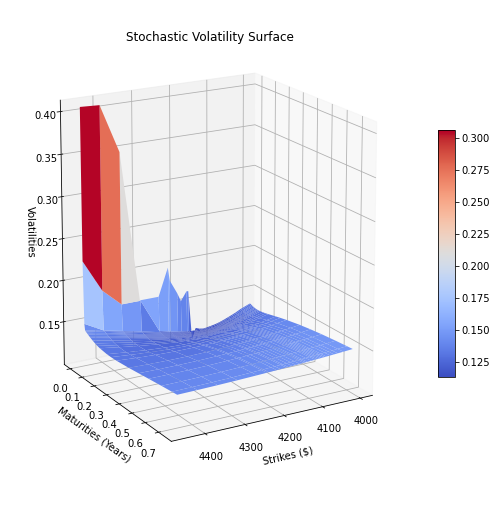

In [ ]:
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)

ax1 = fig.add_subplot(2, 2, 1, projection='3d',xlabel='Strikes ($)',ylabel='Maturities (Years)', zlabel='Volatilities',title='Stochastic Volatility Surface')
surf1=ax1.plot_surface(X, Y, SVs, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0.1)
fig.colorbar(surf1, shrink=0.5, aspect=15)
ax1.view_init(elev=15, azim = 60)

## Experiments

In [ ]:
# Set seed to make random processes deterministic
random.seed(0)

In [ ]:
# Helper Functions For Creating Continuous Function of 2D Points

def linear_interpolate(X, Y, Z):
    return LinearNDInterpolator(np.stack([X,Y], axis=2).reshape((-1,2)), Z.reshape((-1,)))

In [ ]:
f_iv = linear_interpolate(X, Y, IVs)
f_lv = linear_interpolate(X, Y, LVs)
f_sv = linear_interpolate(X, Y, SVs)



**Modeling the Implied Distribution of Spot Prices using the Euler–Maruyama method:**

$w_{i+1} = w_i + \mu w_i \Delta t_i + \sigma w_i \Delta W_i$ 

In [ ]:
# Euler Maruyama Approximation where sigma is a function
def EM(S0, mu, sigma, total_steps, T):
    dt = T/total_steps  #step size
    wi = [S0]
    t = [0]
    static_sigma = None
    for i in range(0,total_steps):
        Winc = random.normal(loc=0.0, scale=np.sqrt(dt), size=None)
        #Pad with edge data if necessary
        if np.isnan(sigma(wi[i],T-i*T/total_steps)):
          if static_sigma is None:
            static_sigma = sigma(wi[i],T-(i-1)*T/total_steps)
          w_i_new = wi[i]+mu*wi[i]*dt+static_sigma*wi[i]*Winc
        else:
          w_i_new = wi[i]+mu*wi[i]*dt+sigma(wi[i],T-i*T/total_steps)*wi[i]*Winc
        wi.append(w_i_new)
        t.append(dt*(i+1))
    return wi, t

In [ ]:
#Plot one possible path using each of the volatility functions for a 5 day span
iv_price, t = EM(s0, r, f_iv, 100, 5/365.25)
lv_price, t = EM(s0, r, f_lv, 100, 5/365.25)
sv_price, t = EM(s0, r, f_sv, 100, 5/365.25)
lv2_price, t = EM(s0, r, lv_interp, 100, 5/365.25)

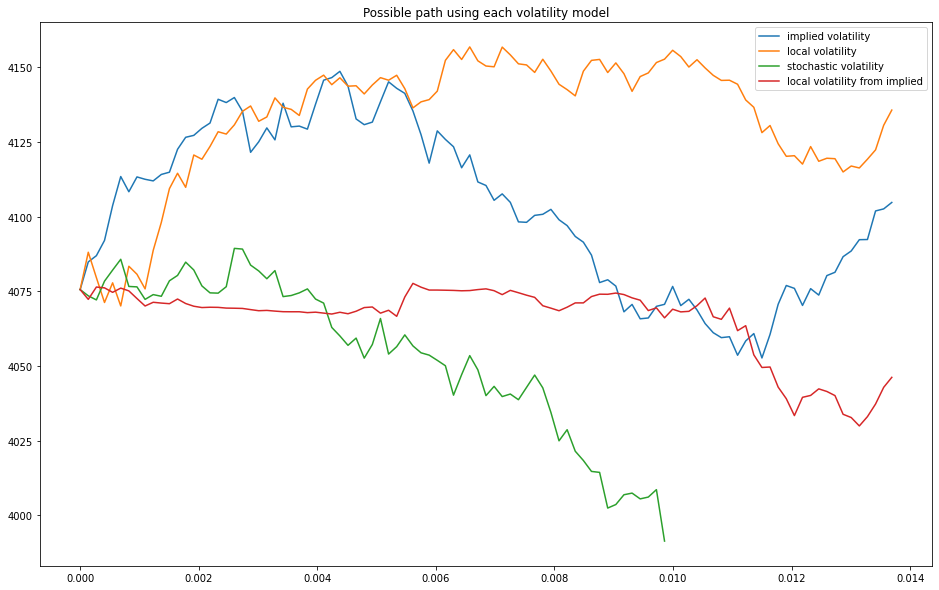

In [ ]:
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(16)
ax = plt.axes()

ax.plot(t, iv_price, label="implied volatility")
ax.plot(t, lv_price, label="local volatility")
ax.plot(t, sv_price, label="stochastic volatility")
ax.plot(t, lv2_price, label="local volatility from implied")

ax.legend()
plt.title("Possible path using each volatility model")
plt.show()

**Comparing the implied distribution to historical data using 90% confidence intervals**

In [ ]:
def remove_nan(l):
  while np.isnan(l[-1]):
    l.pop(-1)
  while np.isnan(l[0]):
    l.pop(0)
  return l

mu = r
def construct_conf_interval(mu):
  #Construct 90% confidence intervals for each implied distribution, and record their ranges
  confidence_interval = [[],[],[],[],[],[],[],[]]
  for i in [1,2,3,6,7,8,9,10,11,14]:
    final_price = [[],[],[],[]]
    for j in range(100):
      iv_price, t = EM(s0, mu, f_iv, 200, i/365.25)
      lv_price, t = EM(s0, mu, f_lv, 200, i/365.25)
      sv_price, t = EM(s0, mu, f_sv, 200, i/365.25)
      lv2_price, t = EM(s0, mu, lv_interp, 200, i/365.25)
      final_price[0].append(iv_price[-1])
      final_price[1].append(lv_price[-1])
      final_price[2].append(sv_price[-1])
      final_price[3].append(lv2_price[-1])
    for k in range(4):
      final_price[k] = sorted(final_price[k])[5:96]
      final_price[k] = remove_nan(final_price[k])
    for k in range(8):
      if k % 2 == 0:
        confidence_interval[k].append(final_price[k//2][0])
      else:
        confidence_interval[k].append(final_price[k//2][-1])
  return confidence_interval

def construct_table(confidence_interval):
  #Put ranges in table
  market_comparison = pd.DataFrame()
  market_comparison['IV low'] = confidence_interval[0]
  market_comparison['IV high'] = confidence_interval[1]
  market_comparison['LV low'] = confidence_interval[2]
  market_comparison['LV high'] = confidence_interval[3]
  market_comparison['SV low'] = confidence_interval[4]
  market_comparison['SV high'] = confidence_interval[5]
  market_comparison['LV from implied low'] = confidence_interval[6]
  market_comparison['LV from implied high'] = confidence_interval[7]

  # Get actual data
  # GSPC is yahoo's name for SPX
  spx_actual = yf.Ticker("^GSPC")
  actual_data = yf.download("^GSPC", start='2021-04-07', end='2021-04-21')
  market_comparison["SPX at close"] = actual_data["Close"].values
  return market_comparison

In [ ]:
#High and low values for each 90% confidence interval given by volatility approximation.
#True value of SPX displayed as last column 
construct_table(construct_conf_interval(r))

[*********************100%***********************]  1 of 1 completed


,IV low,IV high,LV low,LV high,SV low,SV high,LV from implied low,LV from implied high,SPX at close
0,4036.882041,4115.899930,4018.147636,4137.888460,4038.075971,4110.539130,4045.432799,4107.748071,4079.949951
1,4034.763433,4134.323828,4030.536348,4141.700090,4034.468096,4144.496093,4050.448267,4110.094511,4097.169922
2,4002.118882,4143.195944,4019.080933,4148.871209,4031.840907,4158.268706,4032.399120,4120.835724,4128.799805
3,4022.677854,4261.073926,4005.438643,4165.810812,4103.331370,4188.260912,4023.822926,4123.247511,4127.990234
4,4032.114317,4289.769744,4013.965752,4183.165470,4014.582362,4004.384263,3985.576153,4165.722608,4141.589844
5,4062.593122,4193.415522,4008.600214,4216.122613,4021.029254,4240.204950,3974.322066,4254.966541,4124.660156
6,4040.507110,4264.630181,4028.812643,4193.202681,4057.907145,4171.624639,3975.144037,4287.679517,4170.419922
7,4047.754866,4183.664353,4007.338955,4181.450364,4056.419678,4275.081439,3978.683249,4292.362472,4185.470215
8,4032.000392,4258.862419,4024.166348,4375.044481,4019.244148,4223.918272,3975.914167,4312.473292,4163.259766
9,3930.680854,4154.508739,4009.119327,4181.975551,4051.222849,4229.488582,3971.300204,4307.347405,4134.939941


In [ ]:
start = "2020-12-30"
end = "2021-04-30"

In [ ]:
vix = yf.Ticker("^VIX")
vixdata = yf.download("^VIX", start=start, end=end)
vixdata["Sigma"] = ((vixdata["Low"] + vixdata["High"])/2)/100
vixdata

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Sigma
Date,,,,,,,
2020-12-30,22.580000,23.150000,22.410000,22.770000,22.770000,0,0.22780
2020-12-31,22.990000,23.250000,21.240000,22.750000,22.750000,0,0.22245
2021-01-04,23.040001,29.190001,22.559999,26.969999,26.969999,0,0.25875
2021-01-05,26.940001,28.600000,24.799999,25.340000,25.340000,0,0.26700
2021-01-06,25.480000,26.770000,22.139999,25.070000,25.070000,0,0.24455
...,...,...,...,...,...,...,...
2021-04-23,18.559999,18.780001,16.799999,17.330000,17.330000,0,0.17790
2021-04-26,17.940001,18.170000,16.870001,17.639999,17.639999,0,0.17520
2021-04-27,17.620001,18.160000,16.969999,17.559999,17.559999,0,0.17565


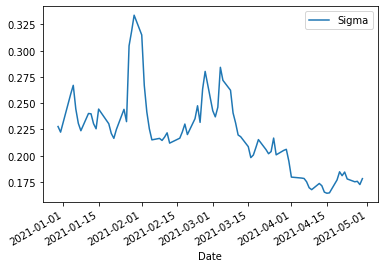

In [ ]:
vixdata.plot.line(y='Sigma')

In [ ]:
# GSPC is yahoo's name for SPX
spx = yf.Ticker("^GSPC")
spxdata = yf.download("^GSPC", start=start, end=end)
spxdata["S"] = (spxdata["Low"] + spxdata["High"])/2
spxdata

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,S
Date,,,,,,,
2020-12-30,3736.189941,3744.629883,3730.209961,3732.040039,3732.040039,3145200000,3737.419922
2020-12-31,3733.270020,3760.199951,3726.879883,3756.070068,3756.070068,3172510000,3743.539917
2021-01-04,3764.610107,3769.989990,3662.709961,3700.649902,3700.649902,5006680000,3716.349976
2021-01-05,3698.020020,3737.830078,3695.070068,3726.860107,3726.860107,4582620000,3716.450073
2021-01-06,3712.199951,3783.040039,3705.340088,3748.139893,3748.139893,6049970000,3744.190063
...,...,...,...,...,...,...,...
2021-04-23,4138.779785,4194.169922,4138.779785,4180.169922,4180.169922,3568080000,4166.474854
2021-04-26,4185.029785,4194.189941,4182.359863,4187.620117,4187.620117,3738920000,4188.274902
2021-04-27,4188.250000,4193.350098,4176.220215,4186.720215,4186.720215,3703240000,4184.785156


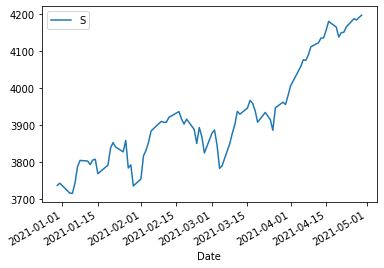

In [ ]:
spxdata.plot.line(y='S')

In [ ]:
spxdata["delta S"] = spxdata["S"].rolling(window=2).apply(lambda x: x.iloc[1]/x.iloc[0])
spxdata["delta S"].iloc[0] = 1
spxdata["T"] = (spxdata.index - spxdata.index.min()).days/365
spxdata

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Open,High,Low,Close,Adj Close,Volume,S,delta S,T
Date,,,,,,,,,
2020-12-30,3736.189941,3744.629883,3730.209961,3732.040039,3732.040039,3145200000,3737.419922,1.000000,0.000000
2020-12-31,3733.270020,3760.199951,3726.879883,3756.070068,3756.070068,3172510000,3743.539917,1.001637,0.002740
2021-01-04,3764.610107,3769.989990,3662.709961,3700.649902,3700.649902,5006680000,3716.349976,0.992737,0.013699
2021-01-05,3698.020020,3737.830078,3695.070068,3726.860107,3726.860107,4582620000,3716.450073,1.000027,0.016438
2021-01-06,3712.199951,3783.040039,3705.340088,3748.139893,3748.139893,6049970000,3744.190063,1.007464,0.019178
...,...,...,...,...,...,...,...,...,...
2021-04-23,4138.779785,4194.169922,4138.779785,4180.169922,4180.169922,3568080000,4166.474854,1.003576,0.312329
2021-04-26,4185.029785,4194.189941,4182.359863,4187.620117,4187.620117,3738920000,4188.274902,1.005232,0.320548
2021-04-27,4188.250000,4193.350098,4176.220215,4186.720215,4186.720215,3703240000,4184.785156,0.999167,0.323288


In [ ]:
s = [s0]
for i in range(len(spxdata.index)):
    s.append(s[-1] * spxdata["delta S"][i])
s.pop(0)
s = np.array(s)
t = spxdata["T"].to_numpy()
inputs = list(zip(s, t))

In [ ]:
def eval_vol(f):
    data = list(filter(lambda x: not math.isnan(x[1]), [[T, float(f(S, T))] for S, T in inputs]))
    return np.array(data)

In [ ]:
vol_paths = [
    ("Local Volatility from Implied", eval_vol(lv_interp)),
    ("Implied Volatility", eval_vol(f_iv)),
    ("Local Volatility from Option Prices", eval_vol(f_lv)),
    ("Stochastic Volatility", eval_vol(f_sv))
]

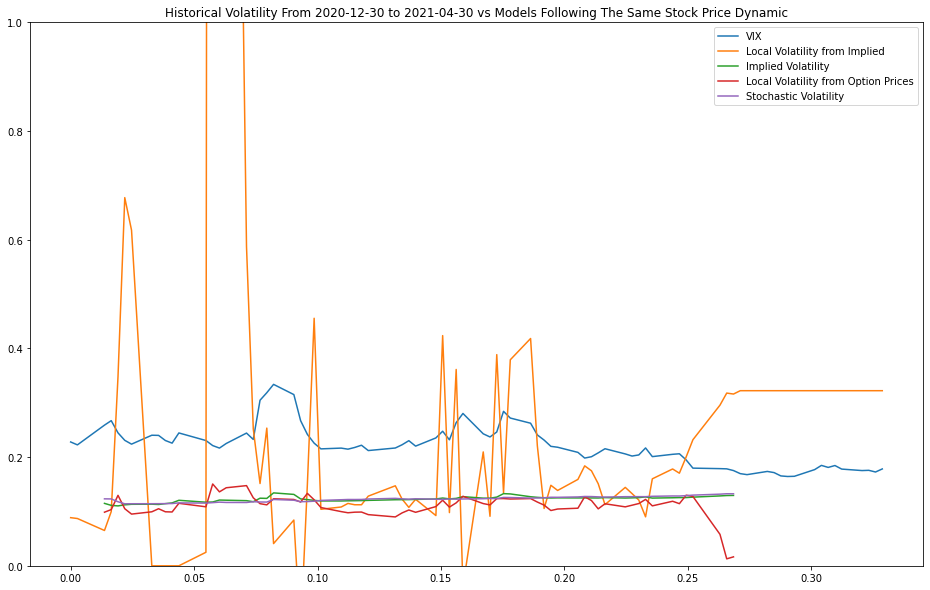

In [ ]:
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(16)
ax = plt.axes()

ax.plot(t, vixdata["Sigma"].to_numpy(), label="VIX")
for path in vol_paths:
    ax.plot(*(path[1].T.tolist()), label=path[0])

ax.set_ylim(bottom=0, top=1)
ax.legend()
plt.title("Historical Volatility From 2020-12-30 to 2021-04-30 vs Models Following The Same Stock Price Dynamic")
plt.show()

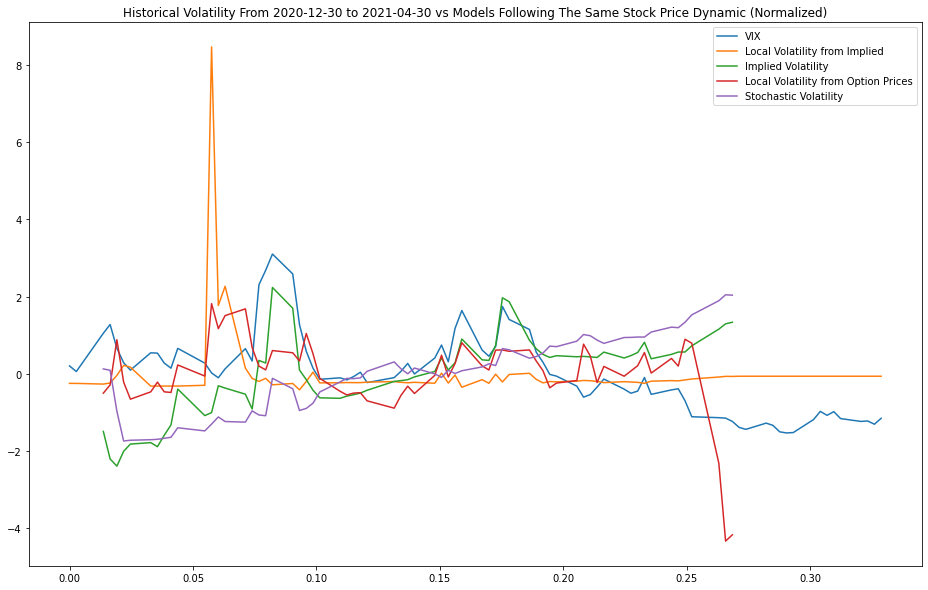

In [ ]:
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(16)
ax = plt.axes()

Y = vixdata["Sigma"].to_numpy()
Y = (Y - np.mean(Y))/np.std(Y)
ax.plot(t, Y, label="VIX")
for path in vol_paths:
    XY = path[1].T
    X = XY[0,:]
    Y = XY[1,:]
    Y = (Y - np.mean(Y))/np.std(Y)
    ax.plot(X, Y, label=path[0])

ax.legend()
plt.title("Historical Volatility From 2020-12-30 to 2021-04-30 vs Models Following The Same Stock Price Dynamic (Normalized)")
plt.show()

In [ ]:
# Distance For Points

print("Scale Invariant Distance From Each Volatility Path To VIX")

vix_X = spxdata["T"].to_numpy()
vix_Y = vixdata["Sigma"].to_numpy()

def calc_diff(Y1, Y2, n):
    return np.sum(np.abs((Y1 - np.mean(Y1))/np.std(Y1) - (Y2 - np.mean(Y2))/np.std(Y2)))/n

rc = random.uniform(size=(len(vix_X,)))
print("Random Control: " + str(calc_diff(vix_Y, rc, len(vix_X))))

for path in vol_paths:
    f = interp1d(path[1].T[0,:], path[1].T[1,:])
    minimum = np.min(path[1][0,:])
    maximum = np.max(path[1][0,:])
    idx = np.argwhere((vix_X > minimum) & (vix_X < maximum))
    X1 = vix_X[idx]
    n = len(X1)
    Y1 = vix_Y[idx]
    Y2 = f(X1)
    print(path[0] + ": " + str(calc_diff(Y1, Y2, n)))

Scale Invariant Distance From Each Volatility Path To VIX
Random Control: 1.20221385672738
Local Volatility from Implied: 1.0163139528200085
Implied Volatility: 0.682909633927186
Local Volatility from Option Prices: 1.1904081096967853
Stochastic Volatility: 1.094664631340643
